# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 20.11.2020

Мягкий дедлайн: 00:59MSK 02.12.2019

Жесткий дедлайн: 00:59MSK 07.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.81839259228212

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
from tqdm import tqdm

def compute_bias_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    preds = []
    # for i in tqdm(range(num_runs)):  очень некрасивая штука
    for i in range(num_runs):
        idx = np.random.randint(0, X.shape[0], X.shape[0])
        idx_ = np.setdiff1d(np.arange(0, y.shape[0]), idx)
        
        y_pred = np.array([np.nan] * y.shape[0])
        y_pred[idx_] = regressor.fit(X[idx], y[idx]).predict(X[idx_])
        preds.append(y_pred)
    y_pred = np.array(preds)
    assert ~np.isnan(y_pred).all(axis=1).any(), 'Invalid argument: a row of nans'
    
    mean_y_pred = np.nanmean(y_pred, axis=0)
    bias = np.mean((mean_y_pred - y)**2)
    
    variance = np.mean(np.nanvar(y_pred, axis=0))
    
    error = np.nanmean((y_pred - y)**2)
    
    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

result = {}
models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
names = ['Линейная регрессия', 'Решающее дерево', 'Случайный лес']

for i in range(3):
    bias, variance, error = compute_bias_variance(models[i], X, y)
    result[names[i]] = [bias, variance, error]
    
pd.DataFrame(result, index=['bias', 'variance', 'error'])

,Линейная регрессия,Решающее дерево,Случайный лес
bias,23.614205,10.479310,10.589947
variance,0.878898,12.953742,2.206347
error,24.423152,23.499226,12.861540


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

<div class="alert alert-block alert-info">
<b>Your answer here:</b> Согласуются. Линейная регрессия не может обучиться достаточно, чтобы вытащить нелинейную закономерность – высокое смещение. Линейные модели довольно устойчивые – низкий разброс. И дерево и лес имеют capacity к обучению – смещение ниже. По дефолту лес строится из десяти деревьев – больше шансов попасть в среднее, чем у одного дерева, отсюда и ниже разброс.</div>

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

<div class="alert alert-block alert-info">
<b>Your answer here:</b> Смещение не меняется ни у одной из моделей, что логично, поскольку метод построения не меняется. В это же время сильно падает разброс. Бэггинг использует десять моделей. Разброс состоит из двух компонент, первая из которых ~ ${1\over{N}}$, где $N$ – количество моделей, вторая представляет собой ковариацию. Ответы линейных моделей не сильно меняются при изменении выборки – нет различий в разбросе. В случайном лесу и так используются композиции – уменьшать разброс уже почти некуда, ковариацию еще можно. Бэггинг над одним деревом дает хорошие результаты: разброс уменьшается на порядок, проблему ковариации уже решить труднее, потому что "рандомности" там мало.</div>

In [9]:
from sklearn.ensemble import BaggingRegressor

models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
names = ['Бэггинг: Линейная регрессия', 'Бэггинг: Решающее дерево', 'Бэггинг: Случайный лес']

for i in range(3):
    bias, variance, error = compute_bias_variance(BaggingRegressor(base_estimator=models[i]), X, y)
    result[names[i]] = [bias, variance, error]

pd.DataFrame(result, index=['bias', 'variance', 'error'])

,Линейная регрессия,Решающее дерево,Случайный лес,Бэггинг: Линейная регрессия,Бэггинг: Решающее дерево,Бэггинг: Случайный лес
bias,23.614205,10.479310,10.589947,23.805388,10.707956,11.642293
variance,0.878898,12.953742,2.206347,1.065487,3.348547,1.390915
error,24.423152,23.499226,12.861540,24.846906,14.017117,12.926910


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [10]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    idx = np.random.randint(0, X.shape[0], num_test_objects)
    idx_ = np.setdiff1d(np.arange(0, y.shape[0]), idx)
    X_train, X_test, y_train, y_test = X[idx_], X[idx], y[idx_], y[idx]
    for i in range(num_runs):
        idx = np.random.randint(0, X_train.shape[0], X_train.shape[0])
        regressor.fit(X_train[idx], y_train[idx])
        y_pred = regressor.predict(X_test)
        pred = plt.scatter(np.arange(num_test_objects), y_pred, c='tab:blue', label='Предсказание')
        plt.ylim(-5, 55)
    ans = plt.scatter(np.arange(num_test_objects), y_test, c='r', label='Ответ')
    plt.legend(handles=[pred, ans])
    plt.title(title, fontsize=15)
    plt.xlabel('Номер объекта')
    plt.ylabel('Предсказание')

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

In [11]:
import seaborn as sns
sns.set(style='whitegrid')

%config InlineBackend.figure_format = 'retina'

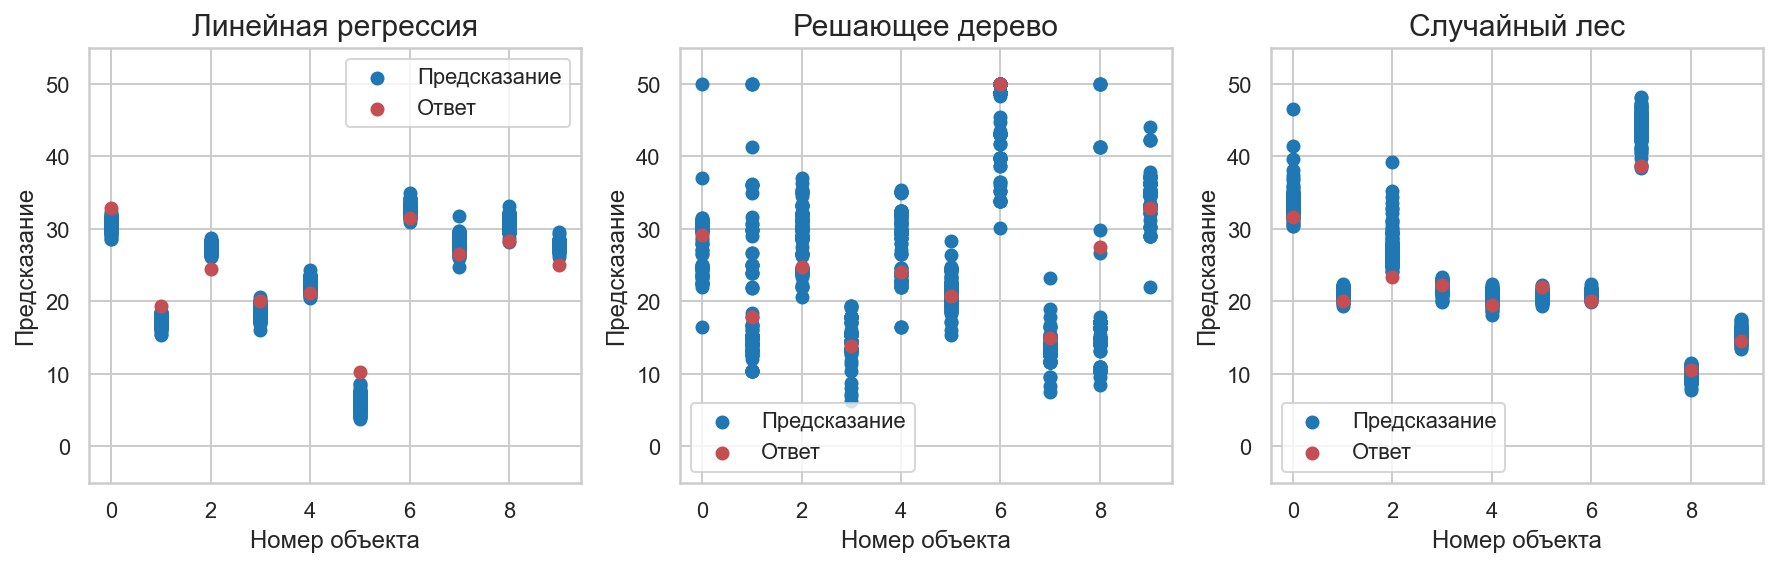

In [12]:
plt.figure(figsize=(15, 4))

models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
titles = ['Линейная регрессия', 'Решающее дерево', 'Случайный лес']

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plot_predictions(models[i], X, y, title=titles[i])

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

<div class="alert alert-block alert-info">
<b>Your answer here:</b> на первом графике заметно смещение линейной модели и небольшой разброс.

На втором, как и ожидалось, смещение сильно ниже, чем у линейных моделей, разброс при этом значительный.

На третьем – случайный лес. Смещение небольшое, разброс на большинстве объектов низкий.

Результаты на графиках совпадают с результатами в таблице.</div>

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [13]:
plt.rcParams['figure.figsize'] = 8, 5

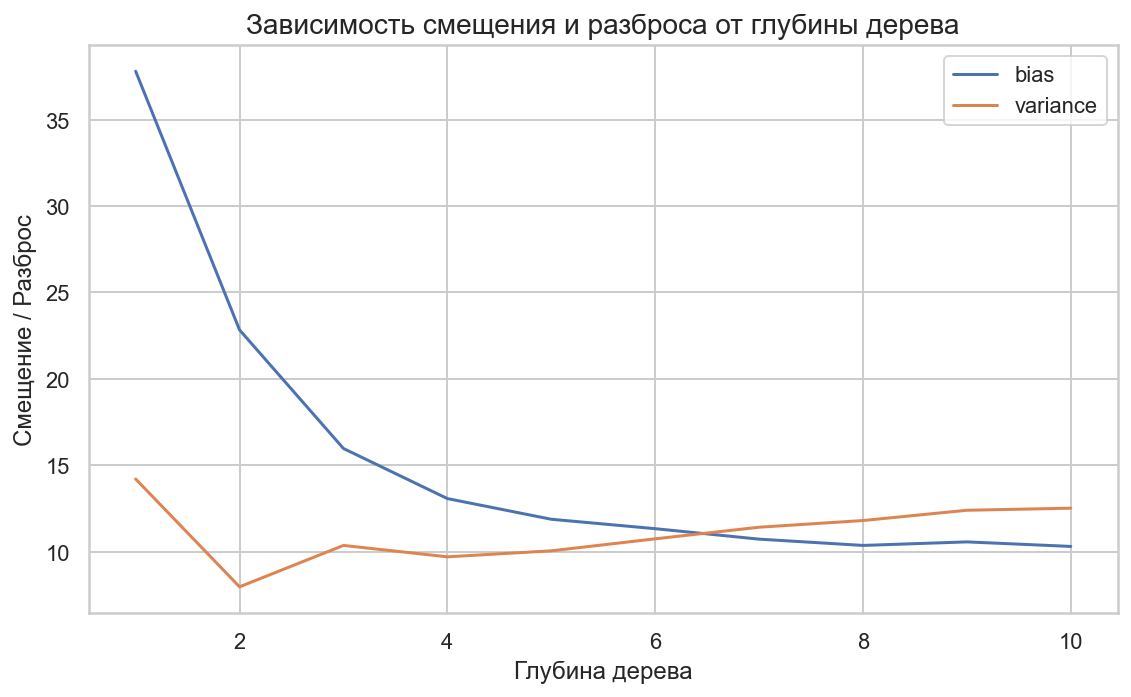

In [14]:
biases, variances = [0] * 10, [0] * 10

for i in range(10):
    biases[i], variances[i], error = compute_bias_variance(DecisionTreeRegressor(max_depth=i + 1), X, y)
    
plt.plot(np.arange(1, 11), biases, label='bias')
plt.plot(np.arange(1, 11), variances, label='variance')
plt.title('Зависимость смещения и разброса от глубины дерева', fontsize=14)
plt.xlabel('Глубина дерева')
plt.ylabel('Смещение / Разброс')
plt.tight_layout()
plt.legend();

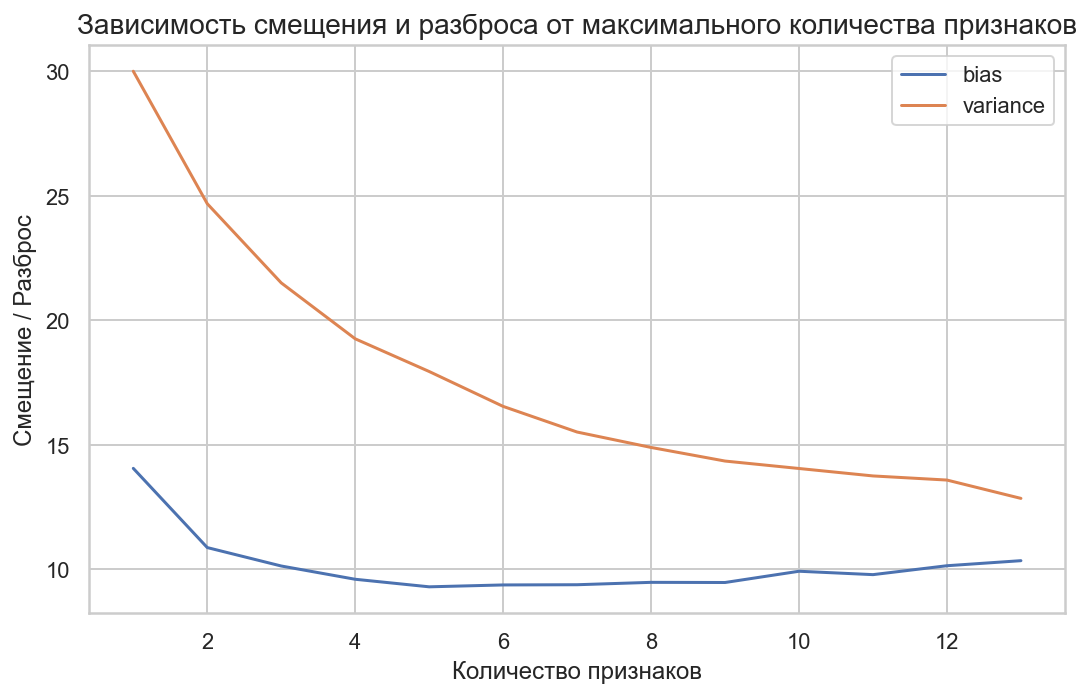

In [15]:
biases, variances = [0] * X.shape[1], [0] * X.shape[1]

for i in range(X.shape[1]):
    biases[i], variances[i], error = compute_bias_variance(DecisionTreeRegressor(max_features=i + 1), X, y)
    
plt.plot(np.arange(1, X.shape[1] + 1), biases, label='bias')
plt.plot(np.arange(1, X.shape[1] + 1), variances, label='variance')
plt.title('Зависимость смещения и разброса от максимального количества признаков', fontsize=14)
plt.xlabel('Количество признаков')
plt.ylabel('Смещение / Разброс')
plt.tight_layout()
plt.legend();

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

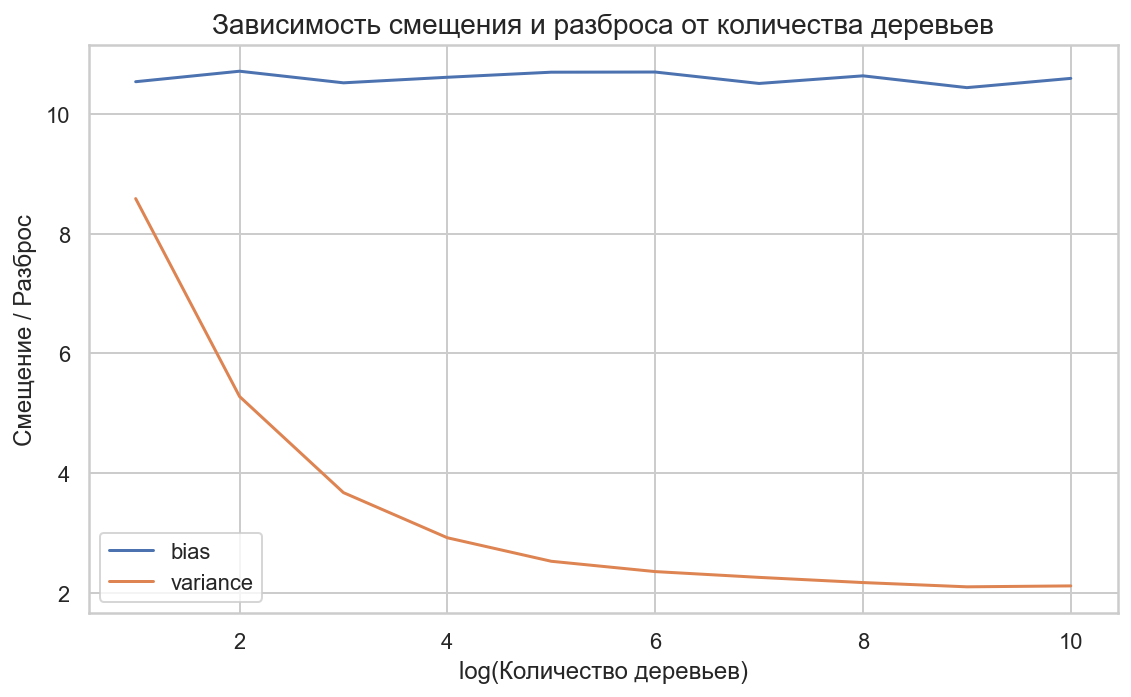

In [16]:
biases, variances = [0] * 10, [0] * 10

for i in range(10):
    biases[i], variances[i], error = compute_bias_variance(
        RandomForestRegressor(n_estimators=2**(i + 1), n_jobs=-1), X, y
    )

plt.plot(np.arange(1, 11), biases, label='bias')
plt.plot(np.arange(1, 11), variances, label='variance')
plt.title('Зависимость смещения и разброса от количества деревьев', fontsize=14)
plt.xlabel('log(Количество деревьев)')
plt.ylabel('Смещение / Разброс')
plt.tight_layout()
plt.legend();

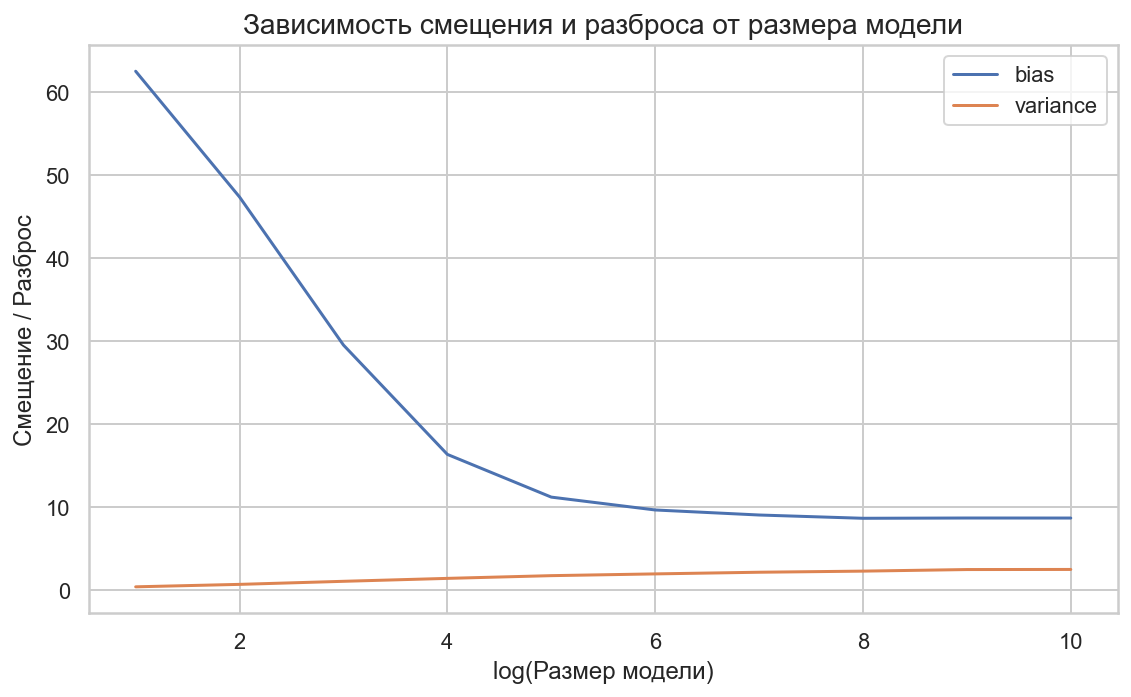

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

biases, variances = [0] * 10, [0] * 10

for i in range(10):
    biases[i], variances[i], _ = compute_bias_variance(
        GradientBoostingRegressor(n_estimators=2**(i + 1)), X, y
    )

plt.plot(np.arange(1, 11), biases, label='bias')
plt.plot(np.arange(1, 11), variances, label='variance')
plt.title('Зависимость смещения и разброса от размера модели', fontsize=14)
plt.xlabel('log(Размер модели)')
plt.ylabel('Смещение / Разброс')
plt.tight_layout()
plt.legend();

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

<div class="alert alert-block alert-info">
<b>BV vs max_depth of a DecisionTree:</b> С увеличением глубины дерева (и его переобучением) смещение сначала резко падает, затем медленнее (поскольку подстроиться под все выбросы сложнее, чем под самые значимые, нужна большая глубина). Разброс, достигая минимума при глубине 2 (вероятно, сумев вытащить основные закономерности, но не успев переобучиться) начинает увеличиваться с каждым новым предикатом, что логично, поскольку в среднем модель может давать не те ответы, что переобученная. (Причем здесь минимальный bias (исходя из графика) не превосходит самое последнее значение bias на следующем графике!)

<b>BV vs max_features of a DecisionTree:</b> Разброс с ростом количества признаков из которых мы выбираем при построении падает, очевидно, потому что модели все больше и больше похожи друг на друга. С увеличением возможности выбора, разумеется, растет шанс вытащить лучшие признаки и поэтому смещение уменьшается, а затем колеблется примерно около десяти. Начинает расти из-за переобучения.

<b>BV vs n_estimators of RandomForestRegressor:</b> поскольку каждое дерево строится по одному и тому же принципу смещение не меняется от их количества, в то время как разброс, напротив, значительно уменьшается, что можно объяснить тем, что среднее (относительно) рандомных ответов стремится к среднему с ростом количества ответов.

<b>BV vs n_estimators GradientBoostingRegressor:</b> каждая последующая модель строится так, чтобы минимизировать ошибку вместе с предыдущей, таким образом смещение при увеличении размера композиции падает. Уменьшение смещения сильно замедляется после определенного момента, поскольку модели строятся простые (в sklearn – неглубокие деревья). Смещение же незначительно увеличивается при значительном росте размера модели за счет того, что композиция каждый раз подстраивается не точно, а с оценкой градиента.</div>